Part 3 - History Dependence
===============================


    

#### code from part 2

In [113]:
from matplotlib.pyplot import *
%matplotlib inline
import numpy as np
import splines
from scipy.ndimage.filters import gaussian_filter1d

def reduce_resolution(array,factor,sum_spikes=True):
    """ 
    Reduces the temporal resolution of an array of spike trains.
    
    This can cause multiple spikes to fall into one time bin, i.e. the
    returned array can contain integers > 1.
    If sum_spikes is set to False, we do not sum spike counts. Instead,
    any spike counts > 1 in one bin are truncated down to 1. In that case,
    a binary array is returned, but some spikes may be lost.
    
    Arguments:
        array: 4D numpy array. Reduction will occur along the last dimension (T).
        factor: integer to divide the number of time bins by.
        sum_spikes: If false, truncate the number of spikes per bin to 1.
      
    Returns:
        4D numpy array, similar as input but last dimension with length T/factor.
    """
    assert type(factor) is int
    reduced_shape = (array.shape[0],array.shape[1],array.shape[2],array.shape[3]/np.round(factor))
    spikes_reduced = np.zeros(reduced_shape) # create a shortened result array
    for idx in np.ndindex(array.shape[0:3]): # for all indices along the first 3 dimensions..
        spiketimes = (array[idx].nonzero()[0] / factor).astype(int) # get spiketimes, divide by factor
        for spiketime in spiketimes: # loop manually, since numpy indexing treats index lists as sets
            spikes_reduced[idx[0],idx[1],idx[2],spiketime] += 1 # increment result array by 1 at the divided spiketimes
    
    if not sum_spikes:
        spikes_reduced  = spikes_reduced >= 1
    spikecount_difference = (np.sum(array) - np.sum(spikes_reduced)).astype(int)
    if spikecount_difference > 0:
        print "Lost "+str(spikecount_difference)+" spikes through resolution reduction."
    return spikes_reduced    

def find_percentiles(y, num_percentiles, return_thresholds=False):
    """ Finds `num_percentiles` equally spaced percentiles of `y` (a monotonically increasing vector),
    i.e. it approximates the inverse `x` of the function `y=f(x)` 
    at `num_percentiles` equally spaced `y`-values between 0 and `y[-1]`.
    
    Arguments:
        y:                  a sequence of monotonically increasing function values
        num_percentiles:    number of percentiles to find between 0 and `y[-1]`.
        return_threshold:   boolean value to indicated whether or not to return the thresholds, too
    Returns:
        percentiles:        `y`-values of the percentiles
        [thresholds:        `x`-values of the percentiles]
    """
    thresholds = np.linspace(0,y[-1],num_percentiles+1)
    percentiles = np.zeros_like(thresholds)
    
    current = 1
    for step in range(T):
        if y[step] > thresholds[current]:
            percentiles[current] = step
            current +=1
    
    percentiles[-1] = len(y)
    if return_thresholds:
        return percentiles, thresholds
    else:
        return percentiles

def calc_cum_abs_deriv(y, sigma=10, order=1):
    """ Calculates the curvature of the spike count vector `y`"""
    return np.cumsum(np.abs(gaussian_filter1d(y, sigma=sigma, order=order)))



# Load the data:
with np.load('data.npz') as archive:
    original_spikes = archive['spikes_outputencoding']

# reduce resolution:
max_spikes_per_bin = 5 # <-- resolution reduction factor
spikes = reduce_resolution(original_spikes,factor=max_spikes_per_bin, sum_spikes=True)

# choose a subset of the data (one cell & one experimental condition):
cell = 1
condition = 1
N = spikes.shape[2] # number of trials
T = spikes.shape[3] # length of a trial
all_spiketrains = spikes[cell,condition,:,:] # N x T array containing only the subset of data that we picked
sum_spiketrains = all_spiketrains.sum(axis=0)
spiketrain0     = all_spiketrains[0]


sigma               = 10
spline_order        = 3
num_knots           = 50


cumulative_derivative = calc_cum_abs_deriv(sum_spiketrains, sigma=sigma, order=1)
adaptive_rate_knots   = find_percentiles(cumulative_derivative, num_knots)
knots                 = splines.augknt(adaptive_rate_knots, spline_order)
rate_spline_bases     = np.array(splines.spcol(range(T),knots,spline_order))

#### Define basis functions for history kernel

In [119]:
import splines
import statsmodels.api as sm

history_length = 100/max_spikes_per_bin
history_spline_order = 3                          
history_num_knots = 4

# Create spline history kernel
history_x = np.linspace(1+1e-10,history_length,history_length)                            # solution
history_knots = splines.augknt(np.logspace(0,np.log10(history_length),history_num_knots),history_spline_order)              # solution
history_knots = history_knots[:-1]
history_spline_bases = np.array(splines.spcol(history_x,history_knots,history_spline_order))   # solution


num_history_bases  = history_spline_bases.shape[1]

(0, 20.1)

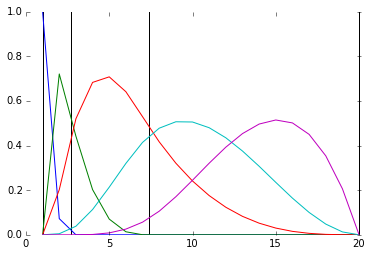

In [111]:
figure()
axes(frameon=False)
plot(np.tile(history_knots,(2,1)),np.zeros((2,len(history_knots)))+np.array([[0],[1]]), "k-")
plot(history_x,history_spline_bases);
xlim([0,history_length+0.1])

#### calculate design matrix of history component for 1 trial

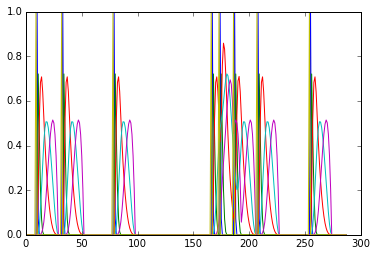

In [102]:
num_basis_functions = history_spline_bases.shape[1]

history_dm = np.zeros((T,num_basis_functions))
for i in range(num_basis_functions):
    history_dm[:,i] = np.convolve(spiketrain0, np.hstack([np.zeros_like(history_spline_bases[:,i]),history_spline_bases[:,i]]), "same")

plot(history_dm[:T/10])
plot(all_spiketrains.ravel()[:T/10])

#### calculate design matrix of history and rate component for 1 trial

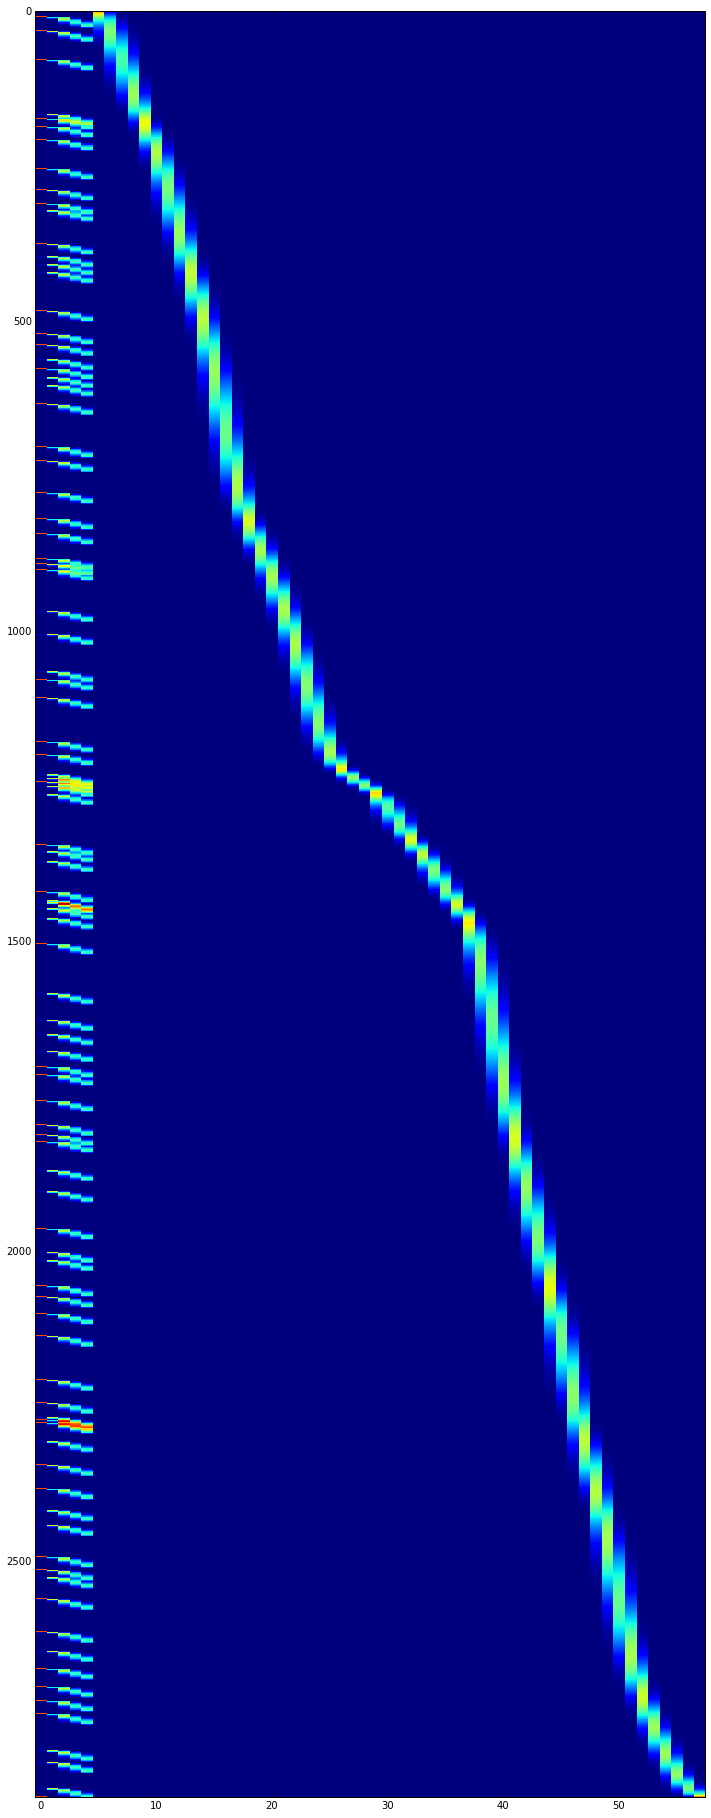

In [104]:
single_trial_dm = np.hstack([history_dm, rate_spline_bases])

figure(figsize=(12,32))
imshow(single_trial_dm, aspect="auto", interpolation="nearest")

#### fit model with rate and history component on 1 spike train (all_spiketrains[0])

In [131]:
spikes_nospikes = np.array([spiketrain0,max_spikes_per_bin-spiketrain0]).T

model = sm.GLM(spikes_nospikes,single_trial_dm,family=sm.families.Binomial())
fitted_model = model.fit()

prediction = fitted_model.predict()

#### plot the components that were learnt and the predicted firing rate for 1 trial (w/ autohistory)

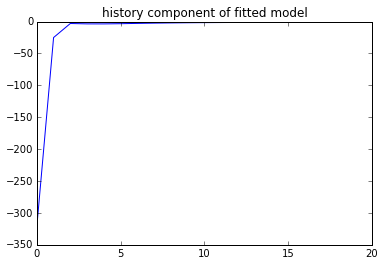

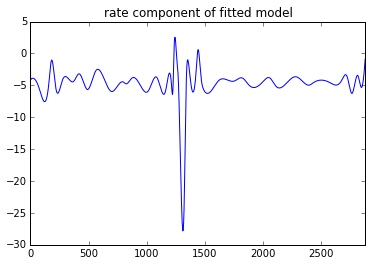

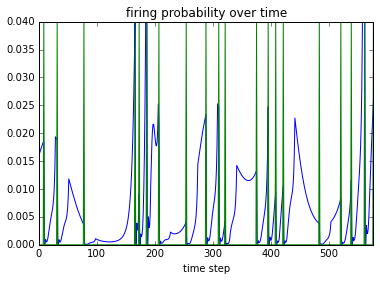

In [116]:
figure()
title('history component of fitted model')
plot(np.dot(history_spline_bases,fitted_model.params[:history_num_knots+1]))
xlim([0,history_spline_bases.shape[0]])

figure()
title('rate component of fitted model')
plot(np.dot(rate_spline_bases,fitted_model.params[history_num_knots+1:]))
xlim([0,T])

figure()

plot(prediction[:T])
plot(spiketrain0*0.04)
xlim([0,T/5])
ylim([0,0.04])
title('firing probability over time')
xlabel('time step')


#### calculate design matrix of the cross-history component for 1 trial

(0, 288)

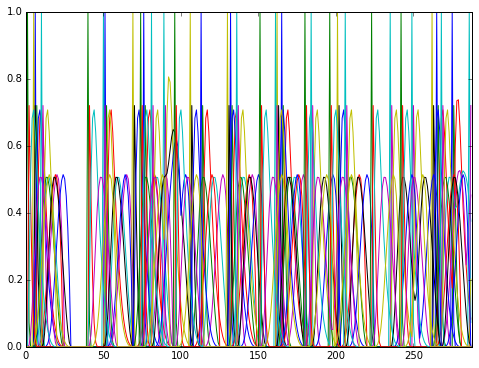

In [126]:
cross_cells        = [0,2,3,4]
cross_spiketrain0  = spikes[cross_cells,condition,0,:]


cross_cell_dms = []

for c in range(len(cross_cells)):
    cross_cell_dm = np.zeros((T,num_history_bases))
    for i in range(num_history_bases):
        cross_cell_dm[:,i] = np.convolve(cross_spiketrain0[c], np.hstack([np.zeros_like(history_spline_bases[:,i]),history_spline_bases[:,i]]), "same")
    cross_cell_dms.append(cross_cell_dm)
    
cross_history_dm = np.hstack(cross_cell_dms)

figure(figsize=(8,6))
plot(cross_history_dm[:T/10]);
xlim([0,T/10])

#### calculate design matrix of the auto-history, cross-history and rate component for 1 trial

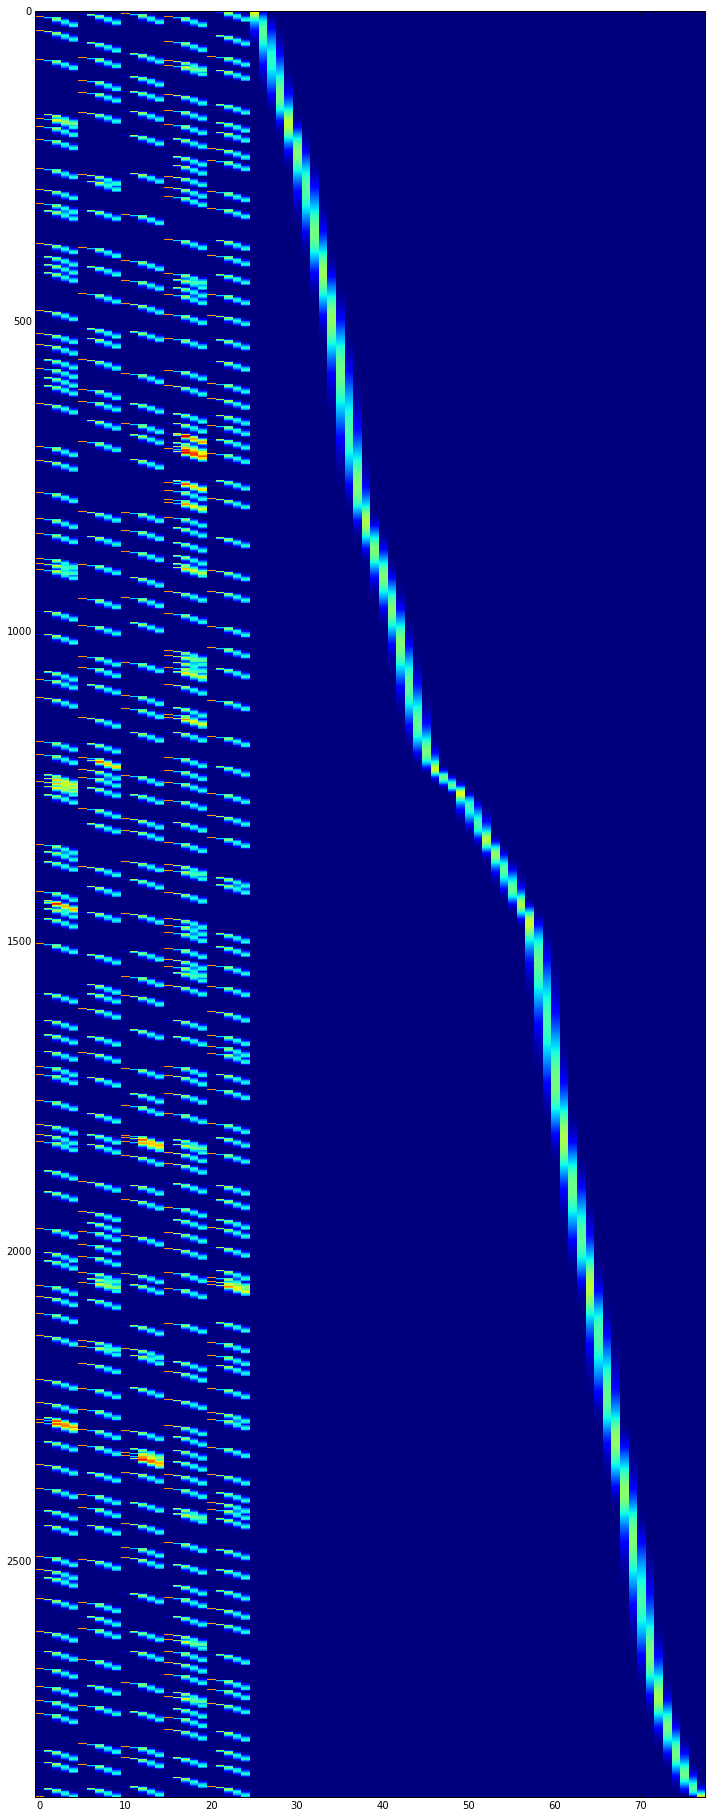

In [138]:
single_trial_dm = np.hstack([history_dm, cross_history_dm, rate_spline_bases])

figure(figsize=(12,32))
imshow(single_trial_dm, aspect="auto", interpolation="nearest")

#### fit model with rate, auto-history and cross-history component on 1 trial

In [132]:
model = sm.GLM(spikes_nospikes,single_trial_dm,family=sm.families.Binomial())
fitted_model = model.fit()
prediction = fitted_model.predict()

In [133]:
auto_history_kernel = np.dot(history_spline_bases,fitted_model.params[:history_num_knots+1])
cross_history_kernels = np.hstack([np.dot(history_spline_bases,fitted_model.params[5+i*5:5+(i+1)*5]).reshape((-1,1)) for i in range(4)])

auto_history_component = np.dot(history_dm,fitted_model.params[:5])
cross_history_components = np.hstack([np.dot(history_dm,fitted_model.params[5+i*5:5+(i+1)*5]).reshape((-1,1)) for i in range(4)])
rate_component = np.dot(rate_dm,fitted_model.params[25:])

#### plot the components that were learnt and the predicted firing rate for 1 trial (w/ autohistory)

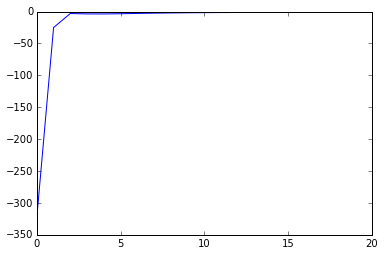

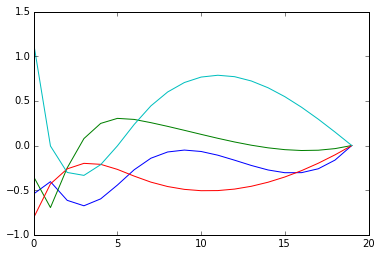

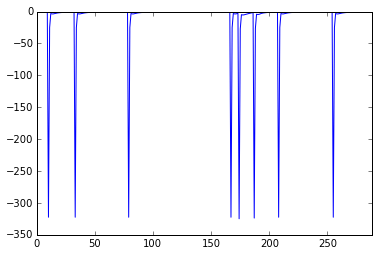

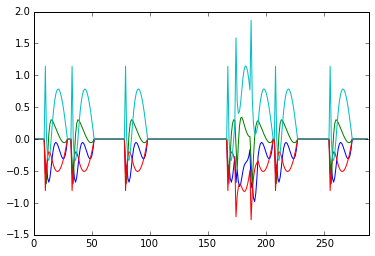

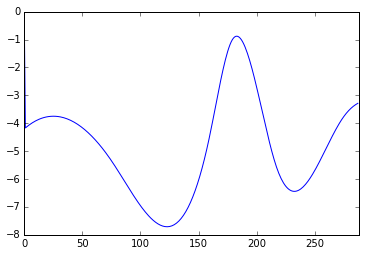

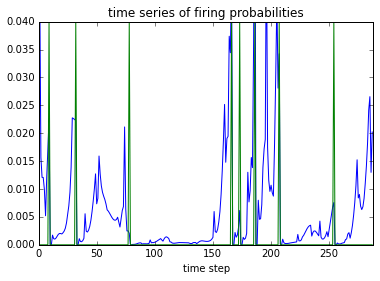

In [137]:
figure()
plot(auto_history_kernel)
xlim([0,len(auto_history_kernel)])

figure()
plot(cross_history_kernels)
xlim([0,len(auto_history_kernel)])

figure()
plot(auto_history_component[:T/10])
xlim([0,T/10])

figure()
plot(cross_history_components[:T/10])
xlim([0,T/10])
figure()
plot(rate_component[:T/10])
xlim([0,T/10])

figure()
plot(prediction[:T/10])
plot(spiketrain0[:T/10]*0.04)
xlim([0,T/10])
ylim([0,0.04])
title('time series of firing probabilities')
xlabel('time step')

#### calculate design-matrix for all trials

In [151]:
num_basis_functions = history_spline_bases.shape[1]
cells =[cell] + cross_cells

dm_list = []
for trial in range(N):
    # Build design-matrix for trial t
    trial_dms = []
    for c,cell in enumerate(cells):
        cell_history_dm = np.zeros((T,num_history_bases))
        for i in range(num_history_bases):
            cell_history_dm[:,i] = np.convolve(spikes[cell,condition,trial,:], np.hstack([np.zeros_like(history_spline_bases[:,i]),history_spline_bases[:,i]]), "same")
        trial_dms.append(cell_history_dm)
    trial_dms.append(rate_spline_bases)
    dm_list.append(trial_dms)

dm = np.array(np.bmat(dm_list))

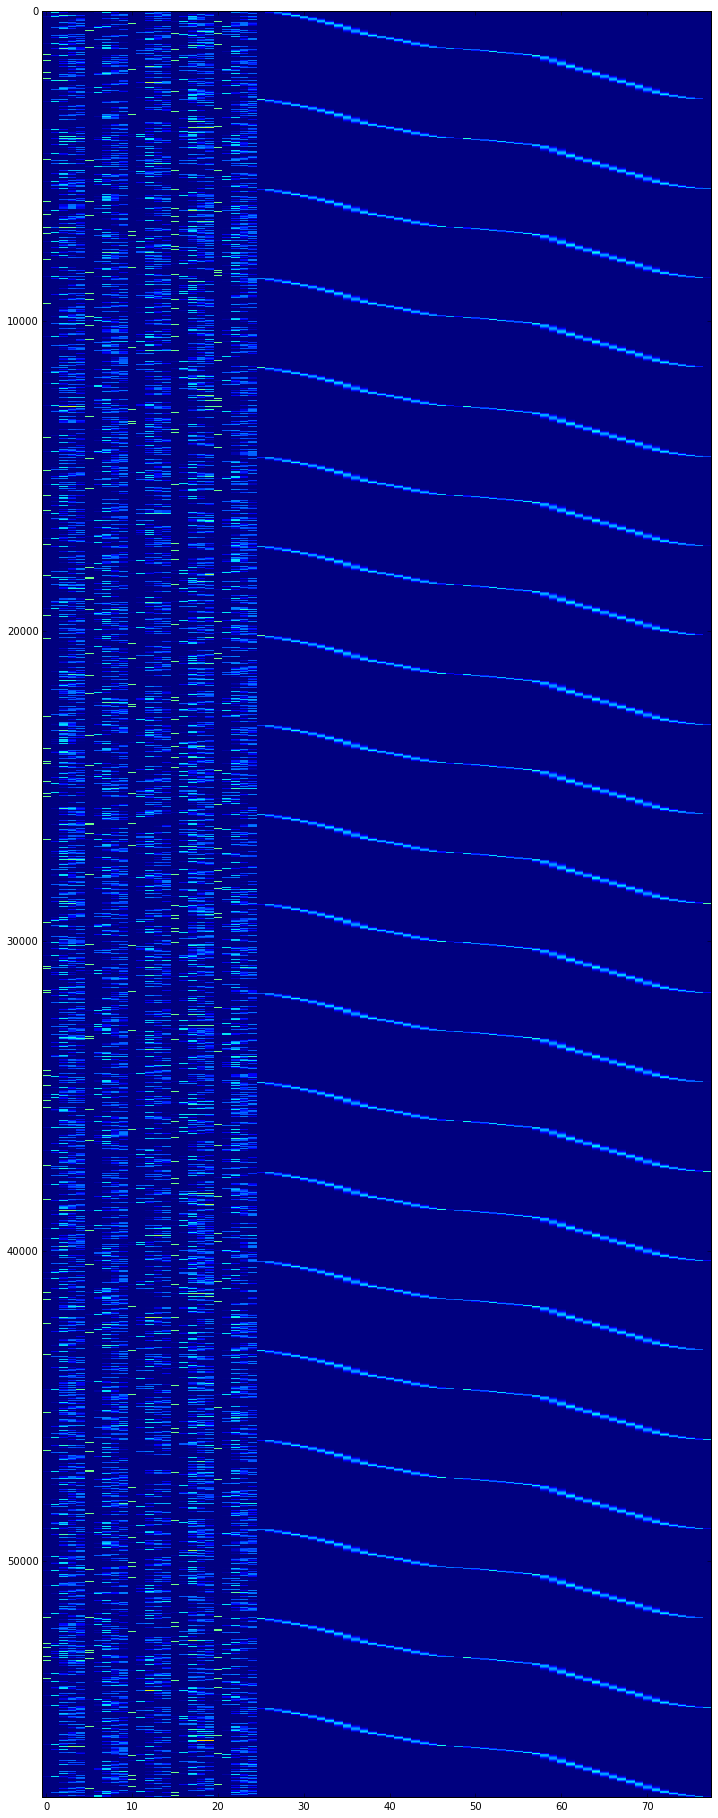

In [152]:
figure(figsize=(12,32))
imshow(dm, aspect="auto", interpolation="nearest")

#### fit model with rate, auto-history and cross-history component on all trials

In [153]:
spikes_nospikes = np.array([all_spiketrains.ravel(),max_spikes_per_bin-all_spiketrains.ravel()]).T

model = sm.GLM(spikes_nospikes,dm,family=sm.families.Binomial())
fitted_model = model.fit()

prediction = fitted_model.predict()

#### plot components that were learn on all trials

In [154]:
auto_history_kernel = np.dot(history_spline_bases,fitted_model.params[:history_num_knots+1])
cross_history_kernels = np.hstack([np.dot(history_spline_bases,fitted_model.params[5+i*5:5+(i+1)*5]).reshape((-1,1)) for i in range(4)])

auto_history_component = np.dot(history_dm,fitted_model.params[:5])
cross_history_components = np.hstack([np.dot(history_dm,fitted_model.params[5+i*5:5+(i+1)*5]).reshape((-1,1)) for i in range(4)])
rate_component = np.dot(rate_dm,fitted_model.params[25:])

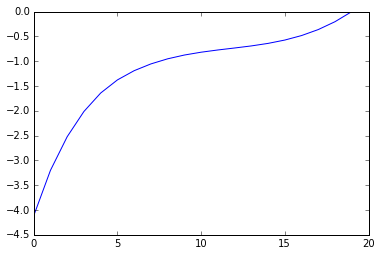

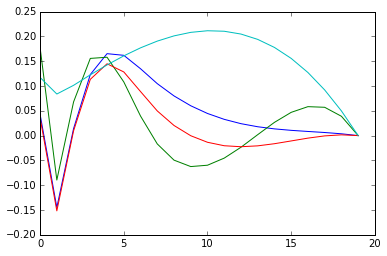

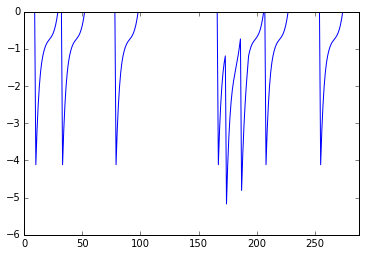

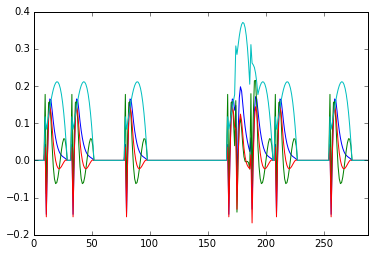

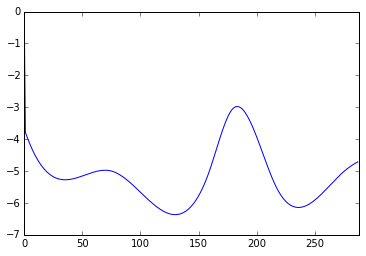

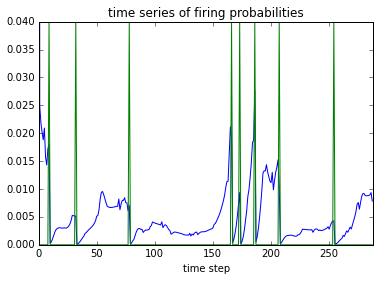

In [158]:
figure()
plot(auto_history_kernel)
xlim([0,len(auto_history_kernel)])

figure()
plot(cross_history_kernels)
xlim([0,len(auto_history_kernel)])

figure()
plot(auto_history_component[:T/10])
xlim([0,T/10])

figure()
plot(cross_history_components[:T/10])
xlim([0,T/10])
figure()
plot(rate_component[:T/10])
xlim([0,T/10])

figure()
plot(prediction[:T/10])
plot(spiketrain0[:T/10]*0.04)
xlim([0,T/10])
ylim([0,0.04])
title('time series of firing probabilities')
xlabel('time step')

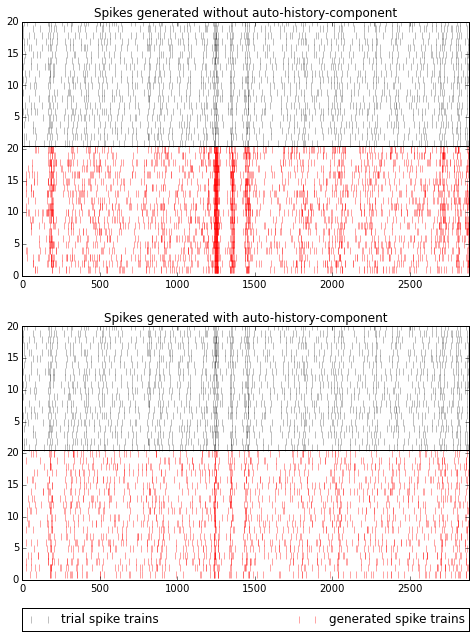

In [162]:
from numpy.random import binomial as binomial_rv

r_and_c_component = np.dot(dm[:,num_history_bases:],fitted_model.params[num_history_bases:]).reshape((N,T))

figure(figsize=(8,10))
ax = [subplot(2,1,1), subplot(2,1,2)]


for i in range(2):
    ax[i].set_title("Spikes generated %s auto-history-component" % ("without" if i==0 else "with"))
    spike_train = np.zeros((N,T))
    for trial in range(N):
        for step in range(history_length,T):
            if i == 0:
                eta = r_and_c_component[trial,step]
            else:
                eta = r_and_c_component[trial,step] + np.dot(spike_train[trial,step-history_length:step],auto_history_kernel)
            p = 1/(1+np.exp(-eta))
            spike_train[trial,step] = binomial_rv(max_spikes_per_bin, p)
    spike_y, spike_t = np.where(spike_train)
    red_dots= ax[i].plot(spike_t,20-spike_y,"r|",alpha=0.7,ms=7)
    
    
spike_y, spike_t = np.where(all_spiketrains)
for i in range(2):
    black_dots = ax[i].plot(spike_t,40-spike_y,"k|",alpha=0.5,ms=7)
    ax[i].plot([0,T],[20.5,20.5],"k-")
    ax[i].set_yticks(np.arange(0,41,5))
    ax[i].set_yticklabels(np.hstack([np.arange(0,21,5),np.arange(5,21,5)]))
    ax[i].set_xlim([0,T])
ax[1].legend([black_dots[0], red_dots[0]], ["trial spike trains","generated spike trains"], bbox_to_anchor=(0., -0.2, 1., -0.2), loc=3, ncol=2, mode="expand", borderaxespad=0)

That's it for Part 3!
==========================